<a href="https://colab.research.google.com/github/xBrymer/COVID19-AI-CT-Scan-Detection/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
import tensorflow_hub as hub

import os 
import shutil
from zipfile import ZipFile
from tqdm.notebook import tqdm

from tensorflow.keras.models import load_model, save_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np


# Prerequisites

In [3]:
path = '/content/drive/My Drive/External Datasets/COVID19-Project/Datasets/main_dataset.zip'

file = ZipFile(path, 'r')
file.extractall()

In [4]:
test_dir = '/content/main/test'
train_dir = '/content/main/train'
val_dir = '/content/main/validation'

In [5]:
img_height = 512
img_width = 512

batch_size = 64

In [29]:
datagen = ImageDataGenerator(rescale = (1/255))

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True
)


test_gen = datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size,
)


val_gen = datagen.flow_from_directory(
    val_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True
)

Found 12789 images belonging to 3 classes.
Found 3173 images belonging to 3 classes.
Found 6350 images belonging to 3 classes.


In [7]:
class_names = ['covid', 'non-covid', 'non-informative']

# Training the model

In [ ]:
pretrained_model = tf.keras.applications.Xception(include_top = False,
                                                  weights = 'imagenet',
                                                  input_shape = (img_height, img_width, 3),
                                                  )
pretrained_model.trainable = False

In [ ]:
model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(.30))
model.add(Dense(3, activation = 'softmax'))


In [ ]:
model.compile(optimizer = Adamax(), loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience =1)

In [ ]:
history = model.fit(train_gen, validation_data= val_gen, epochs = 5, callbacks = es)

Epoch 1/5
200/200 [==============================] - 932s 5s/step - loss: 0.4536 - accuracy: 0.7551 - val_loss: 0.2410 - val_accuracy: 0.9184
Epoch 2/5
200/200 [==============================] - 923s 5s/step - loss: 0.3596 - accuracy: 0.7971 - val_loss: 0.1814 - val_accuracy: 0.9337
Epoch 3/5
200/200 [==============================] - 923s 5s/step - loss: 0.3415 - accuracy: 0.8048 - val_loss: 0.1798 - val_accuracy: 0.9328
Epoch 4/5
200/200 [==============================] - 924s 5s/step - loss: 0.3304 - accuracy: 0.8099 - val_loss: 0.1392 - val_accuracy: 0.9504
Epoch 5/5
200/200 [==============================] - 924s 5s/step - loss: 0.3246 - accuracy: 0.8122 - val_loss: 0.1516 - val_accuracy: 0.9439


In [ ]:
metrics = model.evaluate(test_gen)

50/50 [==============================] - 155s 3s/step - loss: 0.1413 - accuracy: 0.9455


In [ ]:
predictions = model.predict(test_gen)

In [ ]:
print(history.history)

{'loss': [0.4535718560218811, 0.3596196472644806, 0.3415086269378662, 0.33039793372154236, 0.3245900869369507], 'accuracy': [0.7551020383834839, 0.7970912456512451, 0.8048322796821594, 0.809914767742157, 0.8121823668479919], 'val_loss': [0.24099843204021454, 0.18137605488300323, 0.17983503639698029, 0.13916246592998505, 0.15155352652072906], 'val_accuracy': [0.9184252023696899, 0.9337007999420166, 0.9327558875083923, 0.9503936767578125, 0.9439370036125183]}


In [ ]:
os.chdir('/content/drive/My Drive/External Datasets/COVID19-Project/successful_models')
model.save('Xception-v2.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'upper_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


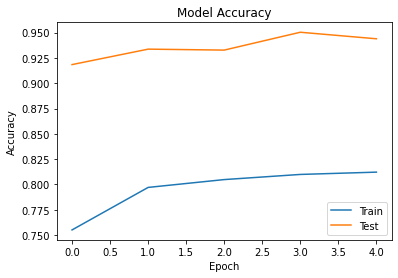

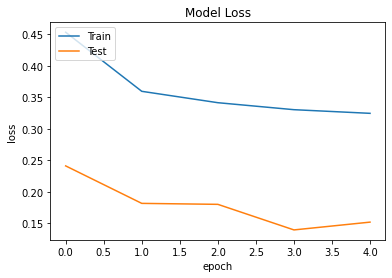

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc = 'upper_left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

# Plotting the confusion matrix

In [8]:
model = load_model('/content/drive/My Drive/External Datasets/COVID19-Project/successful_models/Xception-v2.h5')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 21,386,795
Trainable params: 525,315
Non-trainable params: 20,861,480
_________________________________________________________________


In [30]:
predictions = model.predict(test_gen)

In [11]:
print(predictions)

[[1.8091941e-01 8.0526924e-01 1.3811385e-02]
 [2.3193788e-02 9.7662354e-01 1.8271182e-04]
 [4.6134543e-02 9.5301223e-01 8.5315265e-04]
 ...
 [5.2049370e-03 9.9182206e-01 2.9729856e-03]
 [2.0031627e-04 6.5147982e-04 9.9914825e-01]
 [2.9847246e-01 6.9905907e-01 2.4685415e-03]]


In [31]:
rounded_predictions = np.argmax(predictions, axis =1)

In [32]:
print(list(rounded_predictions))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [41]:
labels = test_gen.classes
print(list(labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [45]:
model.evaluate(test_gen)

50/50 [==============================] - 70s 1s/step - loss: 0.1413 - accuracy: 0.9455


[0.1412554681301117, 0.9454774856567383]

In [43]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


In [37]:
class_names = ['covid','non-covid', 'non-informative']

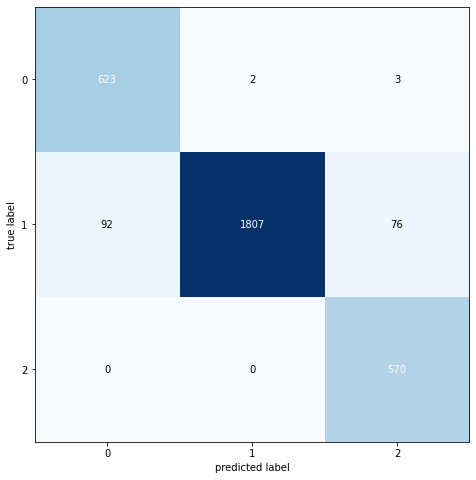

In [44]:
cs = confusion_matrix(labels, rounded_predictions)
cm = plot_confusion_matrix(conf_mat = cs, figsize =(8,8))